Mount drive and import libraries

In [5]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import libraries
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os
import shutil

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define custom ImageFolder class
class ImageFolderWithFilenames(ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path, _ = self.samples[index]
        filename = path.split('/')[-1]
        return original_tuple + (filename,)

Mounted at /content/drive


Unzip dataset and clean invalid files

In [7]:
# Path to dataset
folder_path = '/content/drive/MyDrive/CPEN355-Project/'
zip_file_path = folder_path + 'USTC_SmokeRS.zip'

# Unzip dataset
if not os.path.exists('/content/dataset'):
    !unzip -q "$zip_file_path" -d /content/dataset

# Remove __MACOSX folder if present
macosx_path = '/content/dataset/__MACOSX'
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)
    print("Removed __MACOSX folder")

# Function to clean up non-image files
def clean_non_image_files(directory):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff")
    for root, dirs, files in os.walk(directory):
        for file in files:
            if not file.lower().endswith(valid_extensions) or file.startswith("._"):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed invalid file: {file_path}")

# Apply cleanup
clean_non_image_files('/content/dataset/USTC_SmokeRS')

# Verify cleaned class folders
class_folders = os.listdir('/content/dataset/USTC_SmokeRS')
print("Class folders:", class_folders)

Removed __MACOSX folder
Removed invalid file: /content/dataset/USTC_SmokeRS/.DS_Store
Class folders: ['Seaside', 'Cloud', 'Smoke', 'Haze', 'Land', 'Dust']


Load Dataset

In [8]:
# Load dataset
dataset = ImageFolderWithFilenames(root='/content/dataset/USTC_SmokeRS', transform=transform)

Split dataset and create DataLoaders

In [9]:
from torch.utils.data import random_split, DataLoader

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Feature Extraction Using Pre-trained CNN

In [10]:
import torch
from torchvision.models import resnet18
import numpy as np

# Load pre-trained ResNet18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification layer
resnet = resnet.to(device)
resnet.eval()  # Set to evaluation mode

# Feature extraction function
def extract_features(data_loader):
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets, _ in data_loader:  # Ignore the filename
            inputs = inputs.to(device)
            outputs = resnet(inputs).squeeze()  # Flatten CNN output
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

# Ensure DataLoaders are defined before this step
# Example: train_loader, val_loader, test_loader

# Extract features for train, validation, and test sets
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

# Verify extracted features
print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


Train features shape: (4357, 512)
Train labels shape: (4357,)
Validation features shape: (933, 512)
Test features shape: (935, 512)


Train Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)

# Save the trained model
import joblib
model_path = '/content/drive/MyDrive/CPEN355-Project/random_forest_model.pkl'
joblib.dump(rf, model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/CPEN355-Project/random_forest_model.pkl


Evaluate the Model

Validation Accuracy: 78.24%


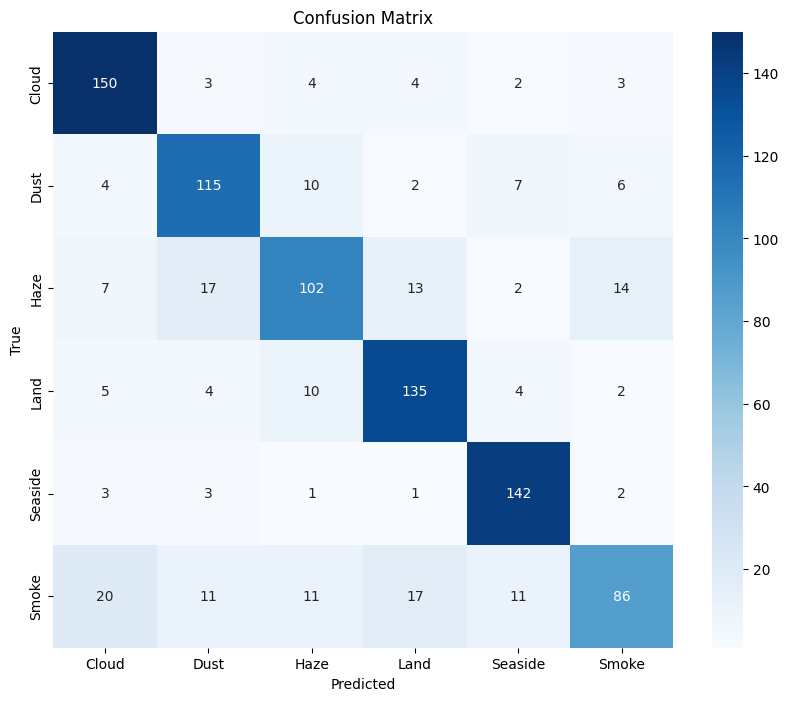

              precision    recall  f1-score   support

       Cloud       0.79      0.90      0.85       166
        Dust       0.75      0.80      0.77       144
        Haze       0.74      0.66      0.70       155
        Land       0.78      0.84      0.81       160
     Seaside       0.85      0.93      0.89       152
       Smoke       0.76      0.55      0.64       156

    accuracy                           0.78       933
   macro avg       0.78      0.78      0.78       933
weighted avg       0.78      0.78      0.78       933



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on validation set
val_predictions = rf.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(val_labels, val_predictions)
class_names = dataset.classes

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(val_labels, val_predictions, target_names=class_names))

Test the model

Test Accuracy: 77.54%


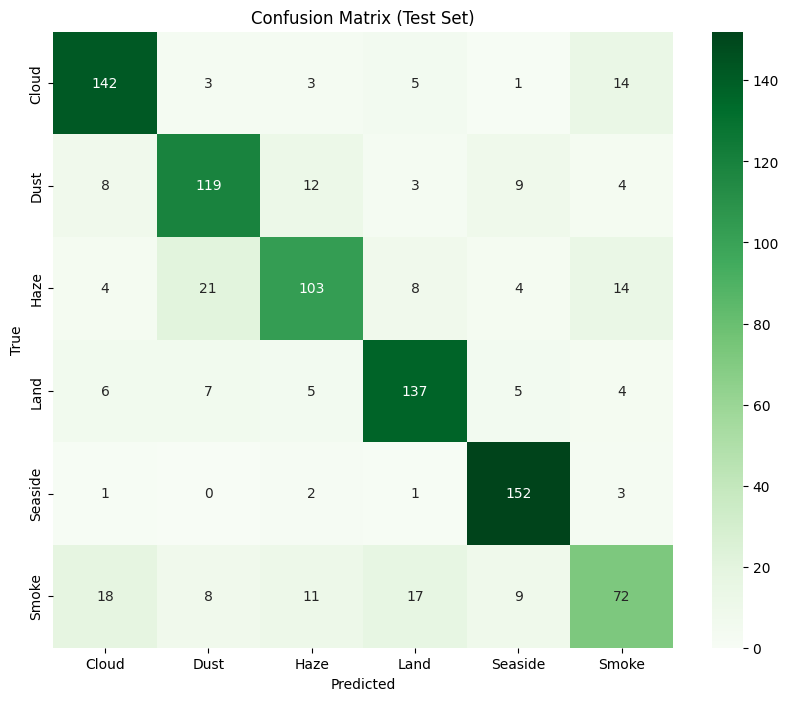

              precision    recall  f1-score   support

       Cloud       0.79      0.85      0.82       168
        Dust       0.75      0.77      0.76       155
        Haze       0.76      0.67      0.71       154
        Land       0.80      0.84      0.82       164
     Seaside       0.84      0.96      0.90       159
       Smoke       0.65      0.53      0.59       135

    accuracy                           0.78       935
   macro avg       0.77      0.77      0.76       935
weighted avg       0.77      0.78      0.77       935



In [13]:
# Predictions on test set
test_predictions = rf.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrix for Test Set
cm_test = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Classification Report for Test Set
print(classification_report(test_labels, test_predictions, target_names=class_names))

Loss Graph

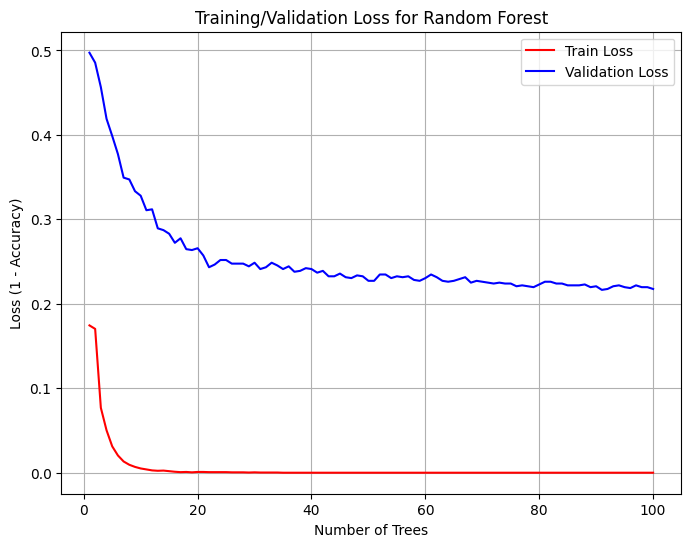

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Use Random Forest model with warm start to simulate training iterations
rf = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42)

train_accuracies = []
val_accuracies = []

# Simulate training process by incrementally adding trees
for i in range(1, 101):  # Train from 1 to 100 trees
    rf.set_params(n_estimators=i)
    rf.fit(train_features, train_labels)

    # Calculate train accuracy
    train_preds = rf.predict(train_features)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_accuracies.append(1 - train_accuracy)  # Convert accuracy to loss

    # Calculate validation accuracy
    val_preds = rf.predict(val_features)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(1 - val_accuracy)  # Convert accuracy to loss

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), train_accuracies, label="Train Loss", color="red")
plt.plot(range(1, 101), val_accuracies, label="Validation Loss", color="blue")
plt.xlabel("Number of Trees")
plt.ylabel("Loss (1 - Accuracy)")
plt.title("Training/Validation Loss for Random Forest")
plt.legend()
plt.grid()
plt.show()